# Compose transport plans across frames

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [33]:
from functools import reduce

import ot
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat 

from otimage import readers, viewers, imagerep
from otimage.utils import plot_maxproj

In [37]:
# Load MP representations of video frames
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.mat'
mp_data = loadmat(mp_path)

# Size of Zimmer images
img_shape = (890, 650, 33)

# TODO: Load this from file
n_frames = 50

cov = mp_data['cov']
pts = [mp_data['means'][t, :, :] for t in range(n_frames)]
wts = [mp_data['weights'][t, :, 0] for t in range(n_frames)]

In [4]:
def compute_ot(pts_1, pts_2, wts_1, wts_2):
        
    # Normalize weights
    p_1 = wts_1 / np.sum(wts_1)
    p_2 = wts_2 / np.sum(wts_2)

    # Normalized distance matrix 
    M_nn = ot.dist(pts_1, pts_2, metric='sqeuclidean')
    M = M_nn / np.median(M_nn)

    # Compute transport plan
    P, _ = ot.emd(p_1, p_2, M, log=True)
    
    return P

In [21]:
t1 = 5
t2 = 10

p_mtx = []
q_mtx = []

for t in range(t1, t2 - 1):
    
    P = compute_ot(pts[t], pts[t + 1], wts[t], wts[t + 1])
    Q = P / np.sum(P, 1)[:, np.newaxis]
    
    p_mtx.append(P)
    q_mtx.append(Q)

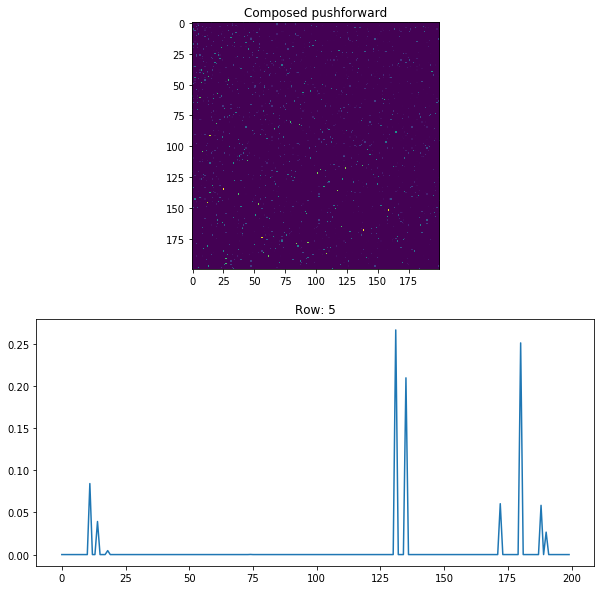

In [32]:
q_comp = reduce(np.matmul, q_mtx)

plt.figure(figsize=(10, 10))

plt.subplot(211)
plt.imshow(q_comp)
plt.title('Composed pushforward')

row_plt = 5
plt.subplot(212)
plt.plot(q_comp[row_plt, :])
plt.title(f'Row: {row_plt}');

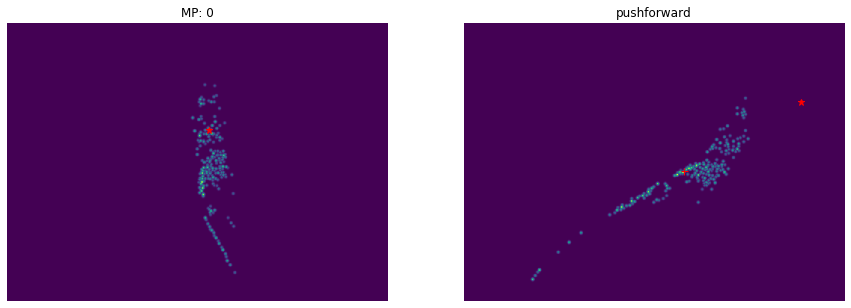

In [38]:
p_comp = p_mtx[0] @ reduce(np.matmul, q_mtx[1:])

viewers.PushforwardViewer(
    pts[t1], pts[t2], wts[t1], wts[t2],
    cov, img_shape, P
);